<a href="https://colab.research.google.com/github/NeulboGom/J_Automation_Project/blob/JH/Anomaly_Classification_no_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.getcwd()

'/content'

In [3]:
import os
from glob import glob
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import csv
import numpy as np

# Image Crop

In [ ]:
# (0, 0, 700, 700) -> (100, 100, 550, 550)
# 이미지 crop 범위를 줄여서 이미지 용량을 줄이는 효과 기대

root = './Dataset'
img_list = glob(os.path.join(root,'**/*.png'),recursive=True)
# glob 경로를 설정하여 리스트로 반환
for img in tqdm(img_list):
    img_data = Image.open(img)
    area = (100,100,550,550)
    cropped_img = img_data.crop(area)
    cropped_img.save(img)

100%|██████████| 123/123 [00:04<00:00, 28.45it/s]


### glob는 경로를 설정하고, 그 안에 있는 파일들을 리스트로 반환한다
### recursive를 False로 두면 그냥 그 경로만, True로 두면 하위 디렉토리까지

In [ ]:
print("recursive = True 일 때")
glob_dir1 = glob('/content/Dataset', recursive = True)

for i in glob_dir1:
    print(i)
    print(type(i))
    print(glob_dir1)
    print(type(glob_dir1))

print()
print("recursive = False 일 때")

glob_dir2 = glob('/content/Dataset', recursive = False)

for i in glob_dir2:
    print(i)
    print(type(i))
    print(glob_dir2)
    print(type(glob_dir2))

recursive = True 일 때
/content/Dataset
<class 'str'>
['/content/Dataset']
<class 'list'>

recursive = False 일 때
/content/Dataset
<class 'str'>
['/content/Dataset']
<class 'list'>


## imshow를 이용한 이미지 출력

In [ ]:
plt.imshow(cropped_img)

# Image to csv by numpy

In [ ]:
timage = cv2.imread('C://Users/cheer/DL/JAuto_Project/Dataset/good_up/1_153911.png')

print(type(timage))
print(timage)

print("Size info:", timage.shape)
print("height:", timage.shape[0])
print("info type:", type(timage.shape[0]))



<class 'numpy.ndarray'>
[[[2 2 2]
  [1 1 1]
  [2 2 2]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [2 2 2]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Size info: (450, 450, 3)
height: 450
info type: <class 'int'>


### Test code

In [42]:
from PIL import Image
import numpy as np
import os

def preprocess_image(image_path, target_size=(450, 450)):
    # 이미지 파일 경로 불러오기
    image_list = glob(os.path.join(image_path, '*.png'))

    # 빈 numpy 배열 생성
    img_array = np.empty((len(image_list), *target_size, 3), dtype=np.uint8)

    for i, img in enumerate(image_list):
        image = Image.open(img)
        image = image.resize(target_size)
        image = image.convert('RGB')  # 흑백 이미지인 경우 컬러로 변환
        img_array[i] = np.array(image)

    return img_array


In [10]:
os.getcwd()

'/content'

In [22]:
# 이미지 전처리
processed_good_up = preprocess_image('/content/drive/MyDrive/Project/good_up')
processed_good_under = preprocess_image('/content/drive/MyDrive/Project/good_under')

# 처리된 이미지의 차원 출력
print(processed_good_up.shape)
print(processed_good_under.shape)

(74, 450, 450)
(49, 450, 450)


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Application

# 폐기

# Model Application

## ResNet Model 가져오기

In [23]:
import tensorflow as tf
import tensorflow.keras as keras

from keras import layers, Model, Input

# 모델 불러오기
model = keras.applications.resnet50.ResNet50(weights = None,
                                             include_top = True,
                                             input_tensor = Input(shape = (450, 450, 3)),
                                             classes = 4)

'''
include_top: 네트워크에 FC-layer를 넣을지 말지 Boolean (커스텀 할지 말지 여부 결정)
weights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기
input_tensor: 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))
pooling: include_top이 False일 때 None, avg, max 중 선택
classes: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수
'''

"\ninclude_top: 네트워크에 FC-layer를 넣을지 말지 Boolean (커스텀 할지 말지 여부 결정)\nweights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기\ninput_tensor: 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))\npooling: include_top이 False일 때 None, avg, max 중 선택\nclasses: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수\n"

## Model Compiling

In [57]:
from keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate = 0.00001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],)

## Train, Test data divide

In [60]:
from sklearn.model_selection import train_test_split

# 정상 이미지 로드
X_normal_up = preprocess_image('/content/drive/MyDrive/Project/good_up')
X_normal_under = preprocess_image('/content/drive/MyDrive/Project/good_under')

# 비정상 이미지 로드
X_abnormal_up = preprocess_image('/content/drive/MyDrive/Project/notgood_up')
X_abnormal_under = preprocess_image('/content/drive/MyDrive/Project/notgood_under')

# 클래스 레이블 생성 (정상 이미지에 대해 0으로 레이블 지정, 비정상 이미지에 대해 1로 레이블 지정)
y_normal_up = np.zeros(len(X_normal_up))
y_normal_under = np.zeros(len(X_normal_under))
y_abnormal_up = np.ones(len(X_abnormal_up))
y_abnormal_under = np.ones(len(X_abnormal_under))

# 정상 이미지와 비정상 이미지를 하나의 데이터로 합치기
X_up = np.concatenate((X_normal_up, X_abnormal_up), axis=0)
X_under = np.concatenate((X_normal_under, X_abnormal_under), axis=0)
y_up = np.concatenate((y_normal_up, y_abnormal_up), axis=0)
y_under = np.concatenate((y_normal_under, y_abnormal_under), axis=0)

# Train, Validation, Test 데이터 나누기
X_train_up, X_val_up, y_train_up, y_val_up = train_test_split(X_up, y_up, test_size=0.2, random_state=42)
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_under, y_under, test_size=0.2, random_state=42)


In [53]:
# 모델 훈련 (정상 데이터만 사용)
model.fit(X_train_up, y_train_up)
model.fit(X_train_under, y_train_under)

2/2 [==============================] - 5s 4s/step - loss: 0.0651 - accuracy: 1.0000


In [ ]:
# 비정상 데이터 로드
X_abnormal = preprocess_image('비정상_이미지_폴더_경로')

# 비정상 데이터를 사용하여 성능 평가
model.evaluate(X_abnormal)

## CSV Dataframe to Image Data

## Model Train

In [61]:
EPOCH = 30
BATCH_SIZE = 3

history_up = model.fit(X_train_up, y_train_up,
                    epochs = EPOCH,
                    verbose = 0,
                    batch_size = BATCH_SIZE,
                    validation_data =(X_val_up, y_val_up))

history_under = model.fit(X_train_under, y_train_under,
                          epochs = EPOCH,
                          verbose = 0,
                          batch_size = BATCH_SIZE,
                          validation_data = (X_val_under, y_val_under))

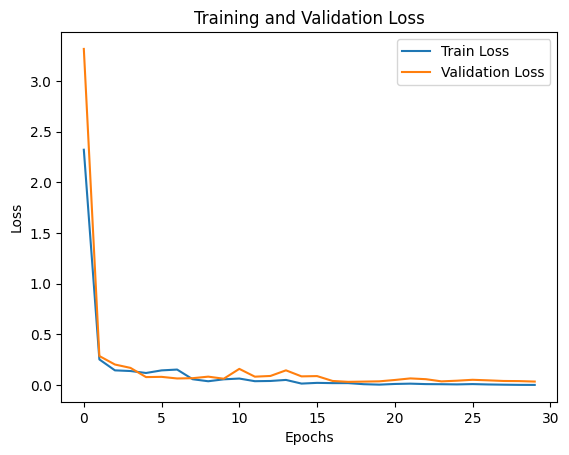

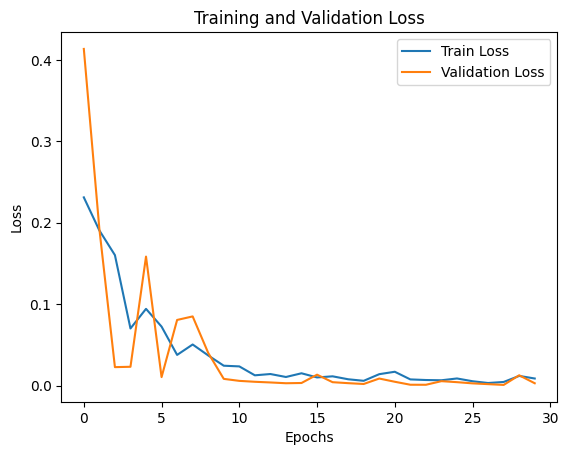

In [65]:
# 훈련 및 검증 손실 그래프
plt.plot(history_up.history['loss'], label='Train Loss')
plt.plot(history_up.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 손실 그래프
plt.plot(history_under.history['loss'], label='Train Loss')
plt.plot(history_under.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

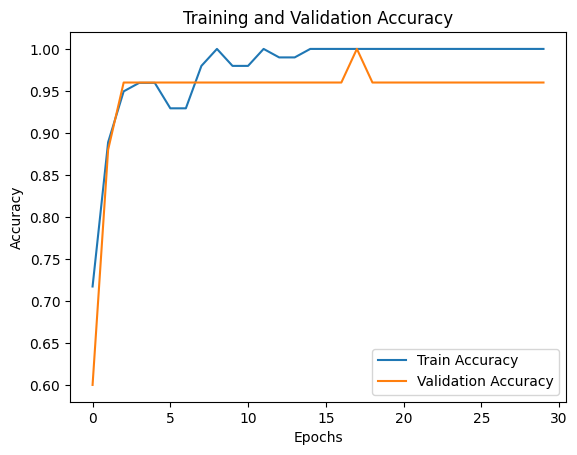

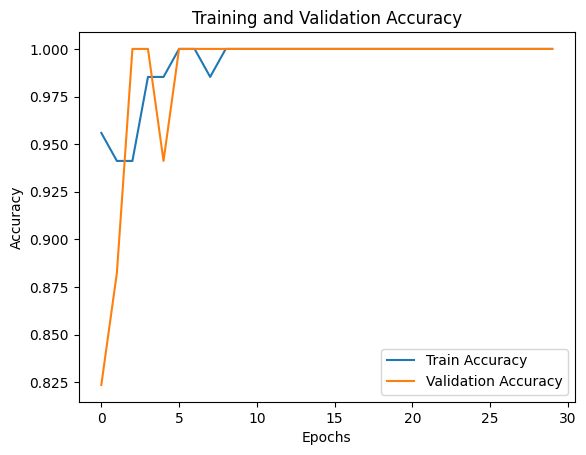

In [66]:
# 훈련 및 검증 정확도 그래프
plt.plot(history_up.history['accuracy'], label='Train Accuracy')
plt.plot(history_up.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 훈련 및 검증 정확도 그래프
plt.plot(history_under.history['accuracy'], label='Train Accuracy')
plt.plot(history_under.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()